In [1]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


In [2]:
X_dim = 6
c_dim = 21
gridSize = 100
z_dim = 5

bs = 256

In [3]:
from data.AttentionDataset import AttentionDataset

train_loader = DataLoader(AttentionDataset(np_file_data = 'data/NarrowPassage/narrowDataOcc100.npz',
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            gridSize = gridSize,
                            train = True),
                         batch_size = bs, shuffle=True, drop_last = True)
test_loader = DataLoader(AttentionDataset(np_file_data = 'data/NarrowPassage/narrowDataOcc100.npz',
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            gridSize = gridSize,
                            train = False),
                          batch_size = bs, shuffle=True, drop_last = True)

In [4]:
import torch.nn.functional as F
   
class AttentionVAE(nn.Module):
    def __init__(self, sample_size, grid_size, cond_size, encoder_layer_sizes, latent_size, decoder_layer_sizes):
        super(AttentionVAE, self).__init__()

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list
        
        self.latent_size = latent_size
        self.condNN = CondNN(sample_size, grid_size, cond_size)
        self.encoder = Encoder(sample_size + cond_size, encoder_layer_sizes, latent_size)
        self.decoder = Decoder(latent_size + cond_size, decoder_layer_sizes, sample_size)

    def condnn(self,startend, occ):
        return self.condNN(startend, occ)
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, startend, occ):
        c, _ = self.condnn(startend, occ)
        mu, logvar = self.encode(torch.cat((x, c), dim=-1))
        z = self.reparameterize(mu, logvar)
        return self.decode(torch.cat((z, c), dim=-1)), mu, logvar
    
    def inference(self, startend, occ, num_viz):
        c, alpha = self.condnn(startend, occ)
        z = torch.randn(num_viz, self.latent_size, device = c.device)
        return self.decode(torch.cat((z, c), dim=-1)), alpha
    
class Encoder(nn.Module):
    def __init__(self, input_size, layer_sizes, latent_size):
        super(Encoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
#             modules.append(nn.Dropout(p=0.5))

        self.sequential = nn.Sequential(*modules)
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x):
        x = self.sequential(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):
    def __init__(self, input_size, layer_sizes, sample_size):
        super(Decoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
#             modules.append(nn.Dropout(p=0.5))
        modules.append(nn.Linear(layer_sizes[-1], sample_size))
        
        self.sequential = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequential(x)


class CondNN(nn.Module):
    def __init__(self, sampleSize, gridSize, outSize, encoder_dim=48, condition_dim=12, attention_dim=48):
        super(CondNN, self).__init__()
        self.CnnEncoder = CnnEncoder(gridSize)
        self.Attention = Attention(encoder_dim + 2, condition_dim, attention_dim) # + 2 for position
        self.fc1 = nn.Linear(attention_dim + 2 + condition_dim, outSize)

    def forward(self, startend, occ):
        encoder_out = self.CnnEncoder(occ)
        attention_weighted_encoding, alpha = self.Attention(encoder_out, startend)
        x = torch.cat((attention_weighted_encoding, startend), dim=-1)
        x = self.fc1(x)
        return x, alpha

class CnnEncoder(nn.Module):
    def __init__(self, gridSize, encoded_image_size=11):
        super(CnnEncoder, self).__init__()
        self.gridSize = gridSize
        self.encoded_image_size = encoded_image_size
        self.cnn = nn.Sequential(
                    nn.Conv2d(1, 6, 5, padding=(2,2)),
                    nn.MaxPool2d(3,3),
                    nn.Conv2d(6, 16, 5, padding=(2,2)),
                    nn.MaxPool2d(2,2),
                    nn.Conv2d(16, 48, 5, padding=(2,2)),
                    nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size)))
            
    def forward(self, images):
        out = self.cnn(images)
        out = out.permute(0, 2, 3, 1) # (batch_size, encoded_image_size, encoded_image_size, 48)
        return out
            
class Attention(nn.Module):
    def __init__(self, encoder_dim, condition_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.condition_att = nn.Linear(condition_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.position = self.initPosition()
    
    def initPosition(self):
        x = np.linspace(0, 10, 11, dtype='float32')
        y = np.linspace(0, 10, 11, dtype='float32')
        xv, yv = np.meshgrid(x,y)
        xv, yv = xv.reshape((1,-1, 1)), yv.reshape((1,-1, 1))
        position = torch.from_numpy(np.concatenate((xv, yv), axis = 2))
        
        return position
        
        
    def forward(self, encoder_out, condition):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        self.position = self.position.to(encoder_out.device)
        self.position = self.position.expand(batch_size, self.position.shape[1], self.position.shape[2])
        encoder_out = torch.cat((encoder_out, self.position), dim = 2)
        
        att1 = self.encoder_att(encoder_out)
        att2 = self.condition_att(condition)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
            
        return attention_weighted_encoding, alpha

In [5]:
model = AttentionVAE(sample_size = X_dim, 
                  grid_size = gridSize, 
                  cond_size = 21,
                  encoder_layer_sizes = [512,1024,512], 
                  latent_size = z_dim, 
                  decoder_layer_sizes = [512,1024,512]).to(device)
print(model)

AttentionVAE(
  (condNN): CondNN(
    (CnnEncoder): CnnEncoder(
      (cnn): Sequential(
        (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (5): AdaptiveAvgPool2d(output_size=(11, 11))
      )
    )
    (Attention): Attention(
      (encoder_att): Linear(in_features=50, out_features=48, bias=True)
      (condition_att): Linear(in_features=12, out_features=48, bias=True)
      (full_att): Linear(in_features=48, out_features=1, bias=True)
      (relu): ReLU()
      (softmax): Softmax()
    )
    (fc1): Linear(in_features=62, out_features=21, bias=True)
  )
  (encoder): Encoder(
    (sequential): Sequential(
      (0): Linear(in

In [6]:
def loss_fn(recon_x, x, w, mean, log_var):
    MSE = torch.mean((w.expand_as(x) * (recon_x-x)**2))
    KLD = - 0.002 * torch.mean(torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), 1))
    return MSE + KLD, MSE

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    mse_loss = 0
    w = torch.tensor([1, 1, 1, 0.5, 0.5, 0.5], dtype=torch.float).to(device)
    for batch_idx, (sample, _, startend, occ) in enumerate(train_loader):
        
        sample, startend, occ = sample.to(device), startend.to(device), occ.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(sample, startend, occ)
        loss, mse= loss_fn(recon_batch, sample, w, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        mse_loss += mse.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

    epoch_loss = train_loss * len(sample) / len(train_loader.dataset)
    epoch_mse = mse_loss * len(sample) / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.7f}'.format(
          epoch, epoch_loss))
    return epoch, epoch_loss, epoch_mse

def test(epoch):
    model.eval()
    test_loss = 0
    mse_loss = 0
    w = torch.tensor([1, 1, 1, 0.5, 0.5, 0.5], dtype=torch.float).to(device)
    for batch_idx, (sample, _, startend, occ) in enumerate(test_loader):
        
        sample, startend, occ = sample.to(device), startend.to(device), occ.to(device)
        recon_batch, mu, logvar = model(sample, startend, occ)
        loss, mse= loss_fn(recon_batch, sample, w, mu, logvar)
        test_loss += loss.item()
        mse_loss += mse.item()

    epoch_loss = test_loss * len(sample) / len(test_loader.dataset)
    epoch_mse = mse_loss * len(sample) / len(test_loader.dataset)
    print('====> Epoch: {} Average test loss: {:.7f}'.format(
          epoch, epoch_loss))
    return epoch, epoch_loss, epoch_mse

In [8]:
epoch = 0
from visdom import Visdom
vis = Visdom(env='attention_100*100')

loss_window = vis.line(
    Y=torch.zeros((1)).cpu(),
    X=torch.zeros((1)).cpu(),
    opts=dict(xlabel='epoch',ylabel='Loss',title='training loss',legend=['loss']))

In [ ]:
for epoch in range(epoch, epoch + 600):
    log_interval = 100
    epoch, epoch_loss, epoch_mse = train(epoch)
    vis.line(X=torch.ones((1,1)).cpu()*epoch,Y=torch.Tensor([epoch_loss]).unsqueeze(0).cpu(),win=loss_window,update='append',name='loss')
    vis.line(X=torch.ones((1,1)).cpu()*epoch,Y=torch.Tensor([epoch_mse]).unsqueeze(0).cpu(),win=loss_window,update='append',name='mse_loss')
    

Train Epoch: 0 [0/66984 (0%)]	Loss: 0.224999
Train Epoch: 0 [25600/66984 (38%)]	Loss: 0.061465
Train Epoch: 0 [51200/66984 (77%)]	Loss: 0.043156
====> Epoch: 0 Average loss: 0.0676512
Train Epoch: 1 [0/66984 (0%)]	Loss: 0.042866


In [ ]:
torch.save(model, 'checkpoints/attention.pt')

In [5]:
torch.cuda.empty_cache()
model = torch.load('checkpoints/attention.pt')
model.eval()

AttentionVAE(
  (condNN): CondNN(
    (CnnEncoder): CnnEncoder(
      (cnn): Sequential(
        (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (5): AdaptiveAvgPool2d(output_size=(11, 11))
      )
    )
    (Attention): Attention(
      (encoder_att): Linear(in_features=50, out_features=48, bias=True)
      (condition_att): Linear(in_features=12, out_features=48, bias=True)
      (full_att): Linear(in_features=48, out_features=1, bias=True)
      (relu): ReLU()
      (softmax): Softmax()
    )
    (fc1): Linear(in_features=62, out_features=21, bias=True)
  )
  (encoder): Encoder(
    (sequential): Sequential(
      (0): Linear(in

5641


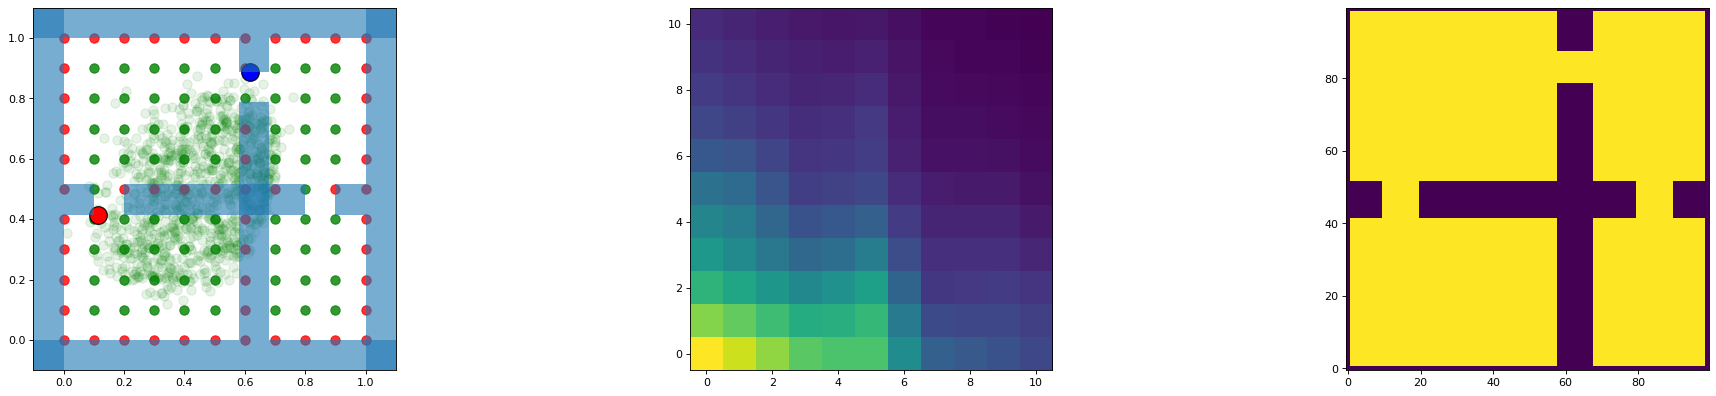

In [30]:
test_data = test_loader.dataset
viz_idx =   torch.randint(0,len(test_data),[1]).item()  
# viz_idx = 8712
print(viz_idx)

_, con, startend, occ = test_data[viz_idx]
startend, occ = torch.tensor(startend), torch.unsqueeze(torch.tensor(occ), 0)

model.eval()
y_viz = torch.randn(1,6).to(device)
for i in range(0, 4):
    num_viz = 256
    y_viz_p, alpha = model.inference(startend.expand(num_viz, X_dim * 2).to(device), 
                            occ.expand(num_viz, 1, gridSize, gridSize).to(device), num_viz)
    torch.cuda.empty_cache()
    y_viz = torch.cat((y_viz_p, y_viz), dim = 0)

y_viz=y_viz.cpu().detach().numpy()
occ=occ.cpu().detach().numpy()

from utils.NarrowPassage import plotCondition, plotSample, plotSpeed, plotSampleAttention

# plotCondition(con)
# plotSample(y_viz, con)
torch.cuda.empty_cache()

occ = occ[0].reshape(100,100)
a = alpha[0].reshape(11,11)
a = a.cpu().detach().numpy()

plotSampleAttention(y_viz, con, occ, a)
# plotCondition(con)
# def plotOcc(img):
#     img = torch.from_numpy(img).permute(1,0)
#     # occ = ndimage.rotate(occ[0], degree*60)
#     plt.imshow(img)
#     plt.gca().invert_yaxis()
# plotOcc(occ)
# plotOcc(a)

# plotSpeed(y_viz, con)

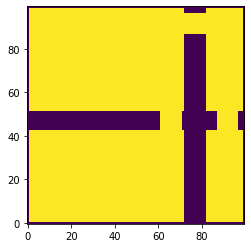

In [16]:
plotOcc(occ)
# plotOcc(a)

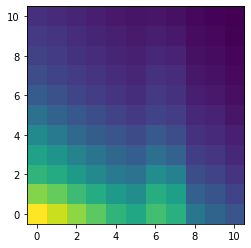

In [17]:

plotOcc(a)